## Proyecto 3 – Agrupación de datos sobre obesidad.
### Carlos Gabriel Contreras

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy.linalg import eigh
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets 
  
# metadata 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.metadata) 
  
# variable information 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables) 


{'uci_id': 544, 'name': 'Estimation of Obesity Levels Based On Eating Habits and Physical Condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Sep 10 2024', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'ID': 358, 'type': 

### Parte 1: Descripción univariada de la información

In [5]:
data = X.copy()

quantitative_vars = data.select_dtypes(include=[np.number])
qualitative_vars = data.select_dtypes(exclude=[np.number])

quantitative_summary = pd.DataFrame({
    'Casos': quantitative_vars.count(),
    'Perdidos': quantitative_vars.isnull().sum(),
    'Media': quantitative_vars.mean(),
    'Intervalo Inferior IC 95%': quantitative_vars.apply(lambda x: stats.t.interval(0.95, len(x.dropna())-1, loc=np.mean(x.dropna()), scale=stats.sem(x.dropna()))[0]),
    'Intervalo Superior IC 95%': quantitative_vars.apply(lambda x: stats.t.interval(0.95, len(x.dropna())-1, loc=np.mean(x.dropna()), scale=stats.sem(x.dropna()))[1]),
    'Desviación Estándar': quantitative_vars.std(),
    'Mínimo': quantitative_vars.min(),
    'Máximo': quantitative_vars.max()
})

qualitative_summary = qualitative_vars.apply(lambda x: x.value_counts(normalize=True, dropna=False)).T
qualitative_summary = qualitative_summary.applymap(lambda x: '' if pd.isna(x) else x)

print("Resumen de Variables Cuantitativas")
display(quantitative_summary) 

print("\nResumen de Variables Cualitativas")
display(qualitative_summary)



Resumen de Variables Cuantitativas


/var/folders/f_/4_ll11tj4236rs5ly_gcd0tm0000gn/T/ipykernel_16000/2406632355.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  qualitative_summary = qualitative_summary.applymap(lambda x: '' if pd.isna(x) else x)


,Casos,Perdidos,Media,Intervalo Inferior IC 95%,Intervalo Superior IC 95%,Desviación Estándar,Mínimo,Máximo
Age,2111,0,24.312600,24.041736,24.583464,6.345968,14.00,61.00
Height,2111,0,1.701677,1.697695,1.705660,0.093305,1.45,1.98
Weight,2111,0,86.586058,85.468145,87.703971,26.191172,39.00,173.00
FCVC,2111,0,2.419043,2.396254,2.441833,0.533927,1.00,3.00
NCP,2111,0,2.685628,2.652419,2.718837,0.778039,1.00,4.00
CH2O,2111,0,2.008011,1.981849,2.034174,0.612953,1.00,3.00
FAF,2111,0,1.010298,0.973992,1.046603,0.850592,0.00,3.00
TUE,2111,0,0.657866,0.631875,0.683857,0.608927,0.00,2.00



Resumen de Variables Cualitativas


,Always,Automobile,Bike,Female,Frequently,Male,Motorbike,Public_Transportation,Sometimes,Walking,no,yes
Gender,,,,0.494079,,0.505921,,,,,,
family_history_with_overweight,,,,,,,,,,,0.182378,0.817622
FAVC,,,,,,,,,,,0.116059,0.883941
CAEC,0.025107,,,,0.114638,,,,0.836097,,0.024159,
SMOKE,,,,,,,,,,,0.979157,0.020843
SCC,,,,,,,,,,,0.954524,0.045476
CALC,0.000474,,,,0.03316,,,,0.663667,,0.3027,
MTRANS,,0.216485,0.003316,,,,0.005211,0.74846,,0.026528,,


In [6]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

# Copia de los datos para análisis
data = X.copy()
data['NObeyesdad'] = y

# Imprimir todas las columnas del dataset
data_columns = data.columns.tolist()
print("Variables en el dataset data:")
print(data_columns)

# Separar variables cuantitativas y cualitativas
quantitative_vars = data.select_dtypes(include=[np.number])
qualitative_vars = data.select_dtypes(exclude=[np.number])

# Mostrar las variables cuantitativas y cualitativas
print("Variables cuantitativas:")
print(quantitative_vars.columns.tolist())
print("\nVariables cualitativas:")
print(qualitative_vars.columns.tolist())

# Verificar si la columna 'NObeyesdad' existe en las variables cualitativas
if 'NObeyesdad' not in qualitative_vars.columns:
    raise ValueError("La columna 'NObeyesdad' no existe en el DataFrame de variables cualitativas.")

# Asegurar que 'NObeyesdad' sea categórica o tipo string
qualitative_vars['NObeyesdad'] = qualitative_vars['NObeyesdad'].astype(str)

# Crear una carpeta para guardar los resultados
os.makedirs("resultados", exist_ok=True)

# Resumen de variables cuantitativas
quantitative_summary = pd.DataFrame({
    'Casos': quantitative_vars.count(),
    'Perdidos': quantitative_vars.isnull().sum(),
    'Media': quantitative_vars.mean(),
    'Intervalo Inferior IC 95%': quantitative_vars.apply(lambda x: stats.t.interval(0.95, len(x.dropna())-1, loc=np.mean(x.dropna()), scale=stats.sem(x.dropna()))[0]),
    'Intervalo Superior IC 95%': quantitative_vars.apply(lambda x: stats.t.interval(0.95, len(x.dropna())-1, loc=np.mean(x.dropna()), scale=stats.sem(x.dropna()))[1]),
    'Desviación Estándar': quantitative_vars.std(),
    'Mínimo': quantitative_vars.min(),
    'Máximo': quantitative_vars.max()
})

# Guardar resumen de variables cuantitativas en Excel
quantitative_summary.to_excel("resultados/resumen_cuantitativas.xlsx")

# Resumen de variables cualitativas
qualitative_summary = qualitative_vars.apply(lambda x: x.value_counts(normalize=True, dropna=False)).T
qualitative_summary = qualitative_summary.applymap(lambda x: '' if pd.isna(x) else x)

# Guardar resumen de variables cualitativas en Excel
qualitative_summary.to_excel("resultados/resumen_cualitativas.xlsx")

print("Resumen de Variables Cuantitativas")
display(quantitative_summary)

print("\nResumen de Variables Cualitativas")
display(qualitative_summary)

# ANOVA y pruebas de comparaciones múltiples
writer = pd.ExcelWriter("resultados/anova_comparaciones_multiples.xlsx", engine='xlsxwriter')

for var in quantitative_vars.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x='NObeyesdad', y=var, palette="Set2")
    
    # Guardar gráfico
    plt.title(f"Distribución de {var} según NObeyesdad")
    plt.xlabel("NObeyesdad")
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"resultados/{var}_boxplot.png")
    plt.close()
    
    # Prueba de Levene para homocedasticidad
    categories = qualitative_vars['NObeyesdad'].unique()
    groups = [data[data['NObeyesdad'] == cat][var].dropna() for cat in categories]
    levene_stat, levene_p = stats.levene(*groups)
    
    # ANOVA
    formula = f'{var} ~ C(NObeyesdad)'
    model = smf.ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA para {var}:")
    print(anova_table)
    anova_table.to_excel(writer, sheet_name=f"ANOVA_{var}")
    
    # Pruebas de comparaciones múltiples
    if levene_p > 0.05:
        # Homocedasticidad: usar Tukey HSD
        from statsmodels.stats.multicomp import pairwise_tukeyhsd
        tukey = pairwise_tukeyhsd(endog=data[var], groups=data['NObeyesdad'], alpha=0.05)
        print(f"Resultados de Tukey HSD para {var}:")
        print(tukey)
        tukey_results = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
        tukey_results.to_excel(writer, sheet_name=f"Tukey_{var}")
    else:
        # Heterocedasticidad: usar prueba de Dunn
        from scipy.stats import kruskal
        from scikit_posthocs import posthoc_dunn
        kruskal_stat, kruskal_p = kruskal(*groups)
        if kruskal_p < 0.05:
            dunn = posthoc_dunn(data, val_col=var, group_col='NObeyesdad', p_adjust='bonferroni')
            dunn_stars = dunn.applymap(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns')))
            print(f"Resultados de Dunn para {var} (significancia):")
            print(dunn_stars)
            dunn_stars.to_excel(writer, sheet_name=f"Dunn_{var}")

# Guardar y cerrar el archivo Excel
writer.close()




Variables en el dataset data:
['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']
Variables cuantitativas:
['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

Variables cualitativas:
['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
Resumen de Variables Cuantitativas


/var/folders/f_/4_ll11tj4236rs5ly_gcd0tm0000gn/T/ipykernel_16000/1883648705.py:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  qualitative_summary = qualitative_summary.applymap(lambda x: '' if pd.isna(x) else x)


,Casos,Perdidos,Media,Intervalo Inferior IC 95%,Intervalo Superior IC 95%,Desviación Estándar,Mínimo,Máximo
Age,2111,0,24.312600,24.041736,24.583464,6.345968,14.00,61.00
Height,2111,0,1.701677,1.697695,1.705660,0.093305,1.45,1.98
Weight,2111,0,86.586058,85.468145,87.703971,26.191172,39.00,173.00
FCVC,2111,0,2.419043,2.396254,2.441833,0.533927,1.00,3.00
NCP,2111,0,2.685628,2.652419,2.718837,0.778039,1.00,4.00
CH2O,2111,0,2.008011,1.981849,2.034174,0.612953,1.00,3.00
FAF,2111,0,1.010298,0.973992,1.046603,0.850592,0.00,3.00
TUE,2111,0,0.657866,0.631875,0.683857,0.608927,0.00,2.00



Resumen de Variables Cualitativas


,Always,Automobile,Bike,Female,Frequently,Insufficient_Weight,Male,Motorbike,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II,Public_Transportation,Sometimes,Walking,no,yes
Gender,,,,0.494079,,,0.505921,,,,,,,,,,,,
family_history_with_overweight,,,,,,,,,,,,,,,,,,0.182378,0.817622
FAVC,,,,,,,,,,,,,,,,,,0.116059,0.883941
CAEC,0.025107,,,,0.114638,,,,,,,,,,,0.836097,,0.024159,
SMOKE,,,,,,,,,,,,,,,,,,0.979157,0.020843
SCC,,,,,,,,,,,,,,,,,,0.954524,0.045476
CALC,0.000474,,,,0.03316,,,,,,,,,,,0.663667,,0.3027,
MTRANS,,0.216485,0.003316,,,,,0.005211,,,,,,,0.74846,,0.026528,,
NObeyesdad,,,,,,0.128849,,,0.135955,0.166272,0.140692,0.153482,0.137376,0.137376,,,,,


ANOVA para Age:
                     sum_sq      df          F        PR(>F)
C(NObeyesdad)  15454.118878     6.0  77.954154  3.592580e-88
Residual       69518.352251  2104.0        NaN           NaN
Resultados de Dunn para Age (significancia):
                    Insufficient_Weight Normal_Weight Obesity_Type_I  \
Insufficient_Weight                  ns           ***            ***   
Normal_Weight                       ***            ns            ***   
Obesity_Type_I                      ***           ***             ns   
Obesity_Type_II                     ***           ***            ***   
Obesity_Type_III                    ***           ***             ns   
Overweight_Level_I                  ***             *            ***   
Overweight_Level_II                 ***           ***             ns   

                    Obesity_Type_II Obesity_Type_III Overweight_Level_I  \
Insufficient_Weight             ***              ***                ***   
Normal_Weight                

/var/folders/f_/4_ll11tj4236rs5ly_gcd0tm0000gn/T/ipykernel_16000/1883648705.py:112: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn.applymap(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns')))
/var/folders/f_/4_ll11tj4236rs5ly_gcd0tm0000gn/T/ipykernel_16000/1883648705.py:112: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn.applymap(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns')))
/var/folders/f_/4_ll11tj4236rs5ly_gcd0tm0000gn/T/ipykernel_16000/1883648705.py:112: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn.applymap(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns')))


ANOVA para Height:
                  sum_sq      df          F        PR(>F)
C(NObeyesdad)   1.814375     6.0  38.432313  1.685854e-44
Residual       16.554841  2104.0        NaN           NaN
Resultados de Dunn para Height (significancia):
                    Insufficient_Weight Normal_Weight Obesity_Type_I  \
Insufficient_Weight                  ns            ns             ns   
Normal_Weight                        ns            ns             ns   
Obesity_Type_I                       ns            ns             ns   
Obesity_Type_II                     ***           ***            ***   
Obesity_Type_III                     ns            ns             ns   
Overweight_Level_I                   ns            ns             ns   
Overweight_Level_II                  ns            **             ns   

                    Obesity_Type_II Obesity_Type_III Overweight_Level_I  \
Insufficient_Weight             ***               ns                 ns   
Normal_Weight                   

/var/folders/f_/4_ll11tj4236rs5ly_gcd0tm0000gn/T/ipykernel_16000/1883648705.py:112: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn.applymap(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns')))
/var/folders/f_/4_ll11tj4236rs5ly_gcd0tm0000gn/T/ipykernel_16000/1883648705.py:112: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn.applymap(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns')))


ANOVA para CH2O:
                   sum_sq      df          F        PR(>F)
C(NObeyesdad)   34.946529     6.0  16.171142  2.837324e-18
Residual       757.805652  2104.0        NaN           NaN
Resultados de Dunn para CH2O (significancia):
                    Insufficient_Weight Normal_Weight Obesity_Type_I  \
Insufficient_Weight                  ns            ns            ***   
Normal_Weight                        ns            ns            ***   
Obesity_Type_I                      ***           ***             ns   
Obesity_Type_II                      ns            ns             **   
Obesity_Type_III                    ***           ***             ns   
Overweight_Level_I                   **           ***             ns   
Overweight_Level_II                  ns             *             ns   

                    Obesity_Type_II Obesity_Type_III Overweight_Level_I  \
Insufficient_Weight              ns              ***                 **   
Normal_Weight                    

/var/folders/f_/4_ll11tj4236rs5ly_gcd0tm0000gn/T/ipykernel_16000/1883648705.py:112: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn.applymap(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns')))
/var/folders/f_/4_ll11tj4236rs5ly_gcd0tm0000gn/T/ipykernel_16000/1883648705.py:112: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn.applymap(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns')))
/var/folders/f_/4_ll11tj4236rs5ly_gcd0tm0000gn/T/ipykernel_16000/1883648705.py:112: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dunn_stars = dunn.applymap(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns')))


ANOVA para TUE:
                   sum_sq      df         F        PR(>F)
C(NObeyesdad)   17.187532     6.0  7.876656  2.068782e-08
Residual       765.184448  2104.0       NaN           NaN
Resultados de Dunn para TUE (significancia):
                    Insufficient_Weight Normal_Weight Obesity_Type_I  \
Insufficient_Weight                  ns            **            ***   
Normal_Weight                        **            ns             ns   
Obesity_Type_I                      ***            ns             ns   
Obesity_Type_II                     ***            ns             ns   
Obesity_Type_III                     **            ns             ns   
Overweight_Level_I                  ***            ns             ns   
Overweight_Level_II                  ns            ns             ns   

                    Obesity_Type_II Obesity_Type_III Overweight_Level_I  \
Insufficient_Weight             ***               **                ***   
Normal_Weight                    ns   

## Paso 2: Análisis de correlaciones, KMO e indice de esfericidad de Bartlet entre variables cuantitativas

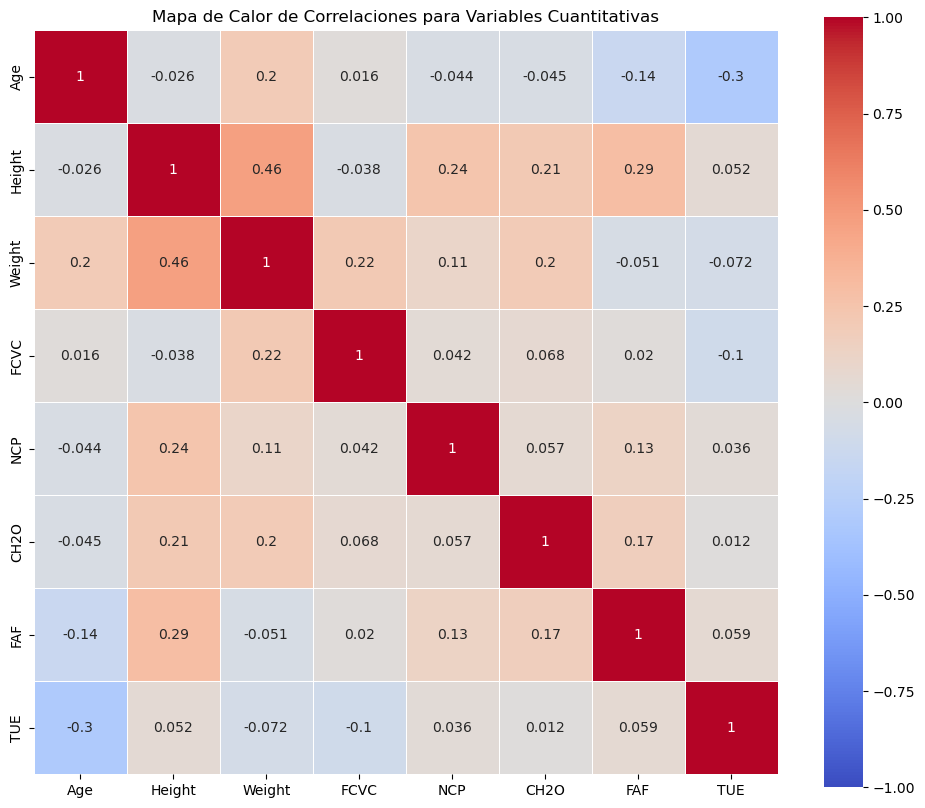

In [11]:
quantitative_vars = X.select_dtypes(include=[np.number])  

correlation_matrix = quantitative_vars.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones para Variables Cuantitativas')
plt.show()


Visualmente, se puede observar algunas nubes de correlación esperadas aunque todas son relaciones débiles. Un supuesto importante para proceder con análisis de componentes principales, implica analizar la esfericidad y la convergencia de la matriz de correlación entre las variables. En este contexto, se procede a ejecutar pruebas estadísticas, Indice KMO y prueba de esfericidad de Barttlet

In [46]:

def calculate_kmo(data):
    corr_matrix = np.corrcoef(data, rowvar=False)
    inv_corr_matrix = np.linalg.inv(corr_matrix)
    n, p = data.shape

    # Calcular KMO
    aii = np.diag(corr_matrix)  # Autocorrelaciones
    bjj = np.diag(inv_corr_matrix)  # Inverso de la autocorrelación
    kmo_num = np.sum(np.abs(corr_matrix) - np.diag(aii))
    kmo_denom = kmo_num + np.sum(np.abs(inv_corr_matrix) - np.diag(bjj))
    kmo_value = kmo_num / kmo_denom

    return kmo_value


def bartlett_sphericity(data):
    corr_matrix = np.corrcoef(data, rowvar=False)
    n, p = data.shape
    chi2_value = -((n - 1) - (2 * p + 5) / 6) * np.log(np.linalg.det(corr_matrix))
    df = p * (p - 1) / 2
    p_value = 1 - chi2.cdf(chi2_value, df)
    return chi2_value, df, p_value

data = quantitative_vars.dropna()  


kmo_value = calculate_kmo(data.values)
print(f'Índice KMO: {kmo_value:.4f}')


chi2_value, df, p_value = bartlett_sphericity(data.values)
print(f'Chi-cuadrado Bartlett: {chi2_value:.4f}, df: {df}, p-value: {p_value:.4f}')


Índice KMO: 0.4451
Chi-cuadrado Bartlett: 1679.3981, df: 28.0, p-value: 0.0000


Con un KMO de 0.4451, los datos muestran una baja adecuación para PCA, sugiriendo que las variables no están suficientemente correlacionadas para identificar factores o componentes significativos. En este caso, puede ser mejor:

1. Revisar las variables para ver si algunas pueden excluirse.
2. Considerar transformar algunas variables.
3. Evaluar si hay otras variables mejor correlacionadas que puedan incorporarse.

La prueba de esfericidad de Bartlett evalúa la hipótesis nula de que la matriz de correlación es una matriz identidad (sin correlación entre variables). Con un p-valor de 0 se rechaza la hipótesis de una matriz de identidad, sugiriendo que hay alguna correlación entre variables.

KMO bajo y Bartlett significativo: El PCA es posible, pero los datos no muestran un ajuste óptimo para este tipo de análisis.

## Paso 3: Análisis de componentes principales entre las variables cuantitativas

1. Se estandarizan los datos y se procede a ejecutar un PCA con datos estandarizados.
2. Usando el método de codo se elige un número eficiente de componentes principales.
3. 5 componentes principales explican el 77% de la varianza
4. Al graficar la componente 1 y 2 (que explican el 22% y 41%) se observa una correlación significativa entre CH20 - Height y NPC
5. Distante a la edad, se observa una correlación relativamente fuerte entre FAF y TUE
6. Correlación fuerte entre edad y FCVC
   

En principio, las componentes principales no estpan correlacionadas entre si y exceptuando la componente 3, tiende a tener una distribución lepticurtica, centrada.

SyntaxError: unterminated string literal (detected at line 78) (2206351577.py, line 78)

## Paso 5: Modelos de clasificación, Kmedias vs Jerárquico

1. Se planifica un algoritmo de KMedias que correrá entre 2 y 11 clusters escogiendo la solución con mejor indice de silueta. Resulta ser una solución con seis clusters.
2. Se propone un algoritmo de cluster jerárquico, tambien entre 2 y 11 clusters. En este método la solución con mejor silueta es 2 clusters.
   

Características del Algoritmo Ganador:
Tipo de Clustering: K-Means
Método: n_clusters: 9 | random_state: 42
Algoritmo: KMeans(n_clusters=9, random_state=42)


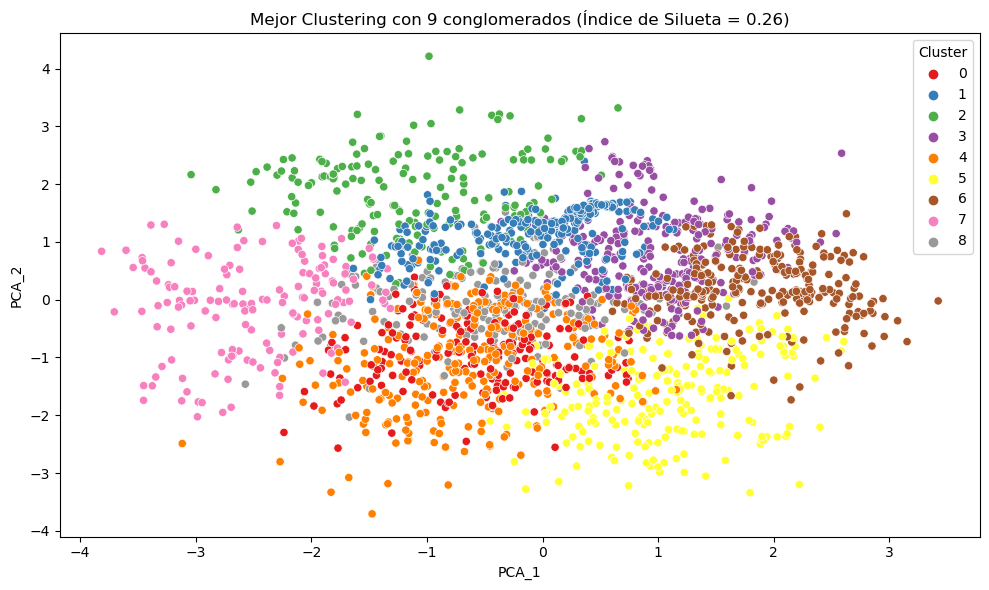

In [50]:

# Clustering Jerárquico y K-Means para 2 a 9 conglomerados usando solo las componentes principales
best_score = -1
best_kmeans_model = None
best_hierarchical_model = None
best_n_clusters = 0

for n_clusters in range(2, 10):
    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(pca_df)
    kmeans_silhouette = silhouette_score(pca_df, kmeans_labels)
    
    # Clustering Jerárquico
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(pca_df)
    hierarchical_silhouette = silhouette_score(pca_df, hierarchical_labels)
    
    # Elegir el mejor modelo basado en el índice de silueta
    if kmeans_silhouette > best_score:
        best_score = kmeans_silhouette
        best_kmeans_model = kmeans
        best_n_clusters = n_clusters
    
    if hierarchical_silhouette > best_score:
        best_score = hierarchical_silhouette
        best_hierarchical_model = hierarchical
        best_n_clusters = n_clusters

# Guardar el mejor modelo y sus etiquetas
if best_kmeans_model:
    clustering_algorithm = "K-Means"
    method = "n_clusters: {} | random_state: 42".format(best_n_clusters)
    algorithm_details = best_kmeans_model
    data['Cluster'] = best_kmeans_model.labels_
else:
    clustering_algorithm = "Jerárquico"
    method = "n_clusters: {}".format(best_n_clusters)
    algorithm_details = best_hierarchical_model
    data['Cluster'] = best_hierarchical_model.labels_

# Imprimir las características del algoritmo ganador
print("Características del Algoritmo Ganador:")
print(f"Tipo de Clustering: {clustering_algorithm}")
print(f"Método: {method}")
print(f"Algoritmo: {algorithm_details}")

# Guardar los datos con los clústeres asignados (solo las componentes principales y clústeres)
result_data = pd.concat([pca_df, data['Cluster']], axis=1)
result_data.to_excel("resultados/data_con_clusters.xlsx", index=False)

# Visualización de los clústeres
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Cluster', data=data, palette='Set1', legend='full')
plt.title(f'Mejor Clustering con {best_n_clusters} conglomerados (Índice de Silueta = {best_score:.2f})')
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.legend(title='Cluster')
plt.tight_layout()

# Guardar el gráfico de clústeres
plt.savefig("resultados/mejor_clustering.png")
plt.show()


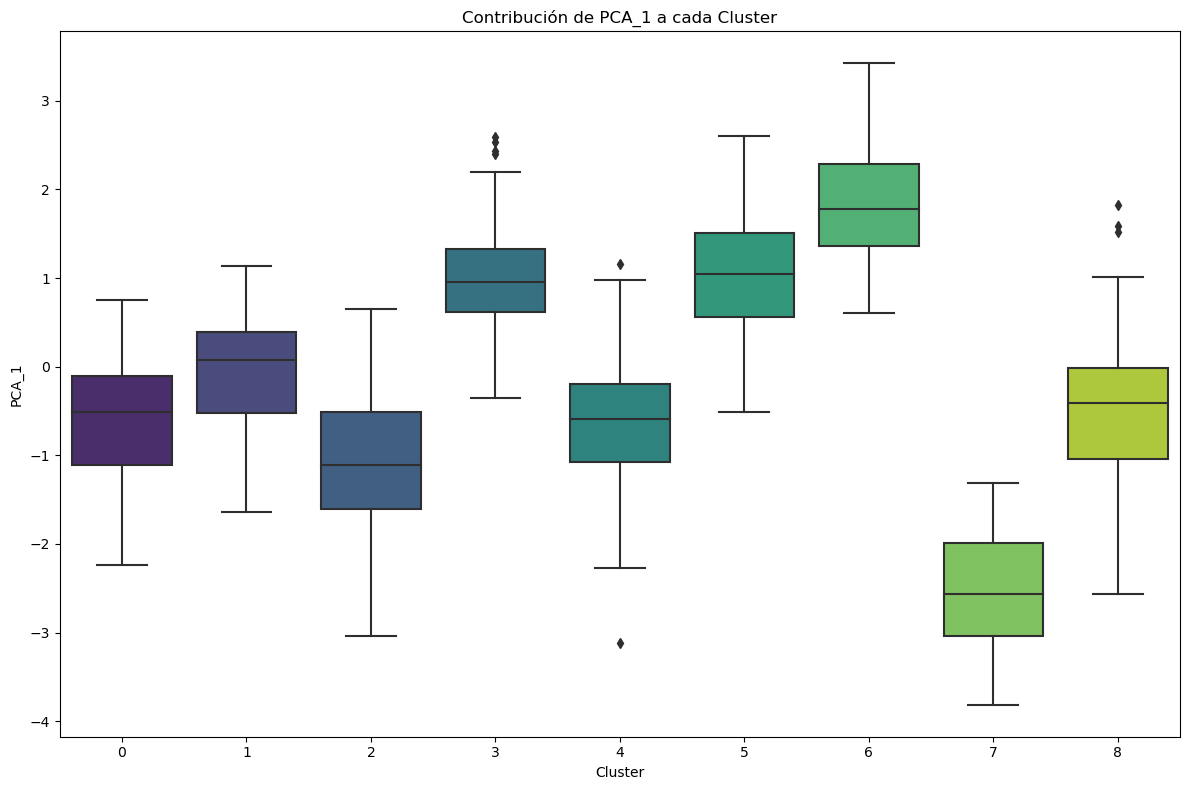

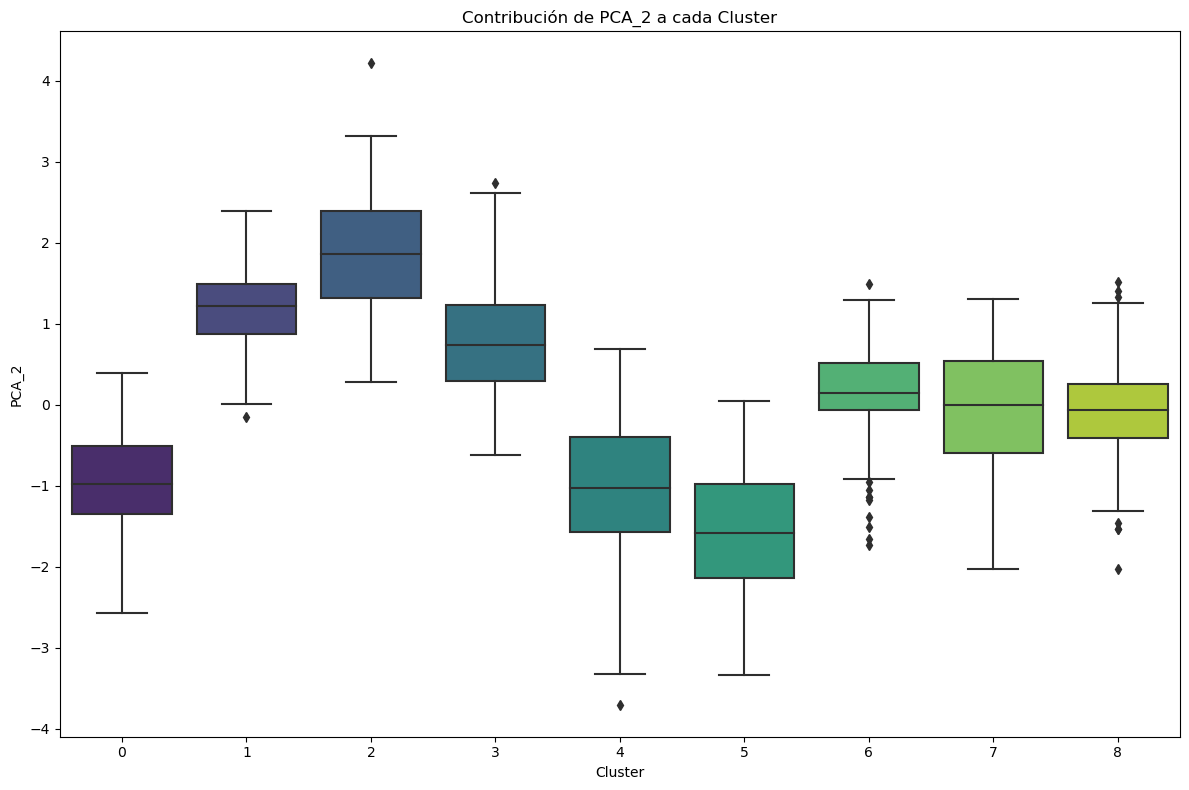

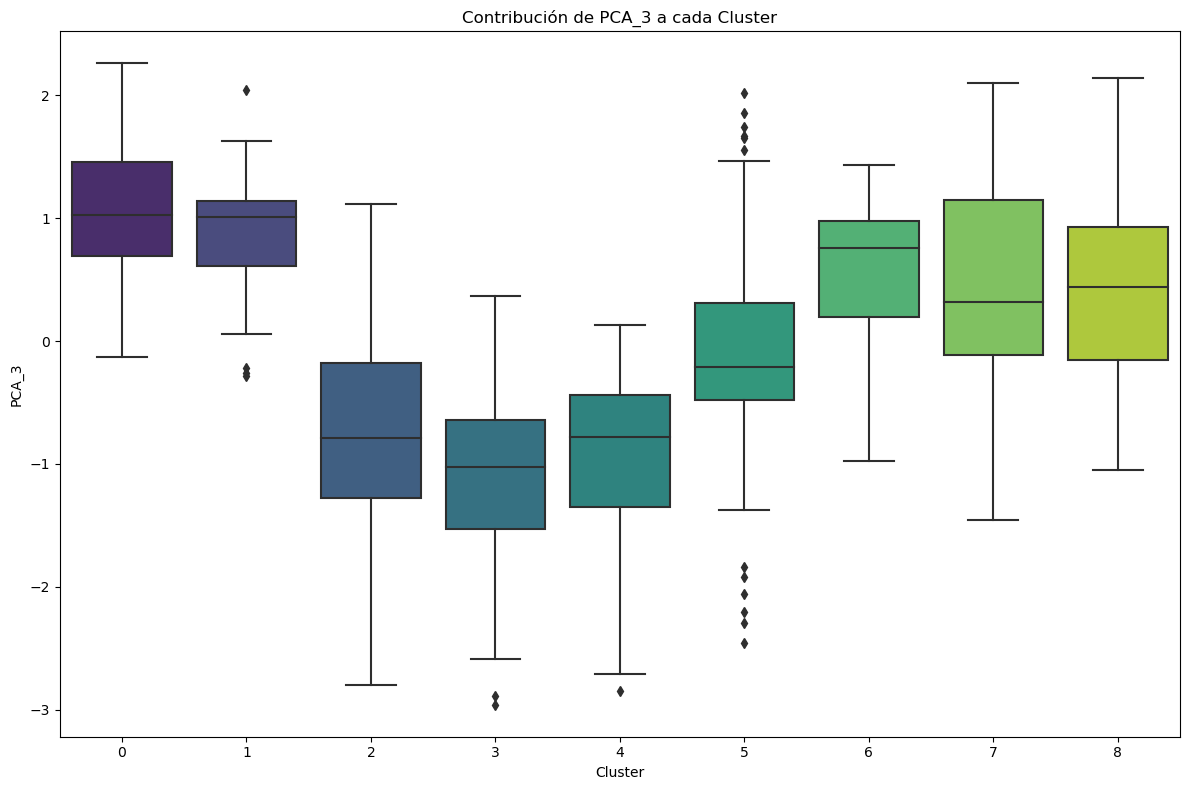

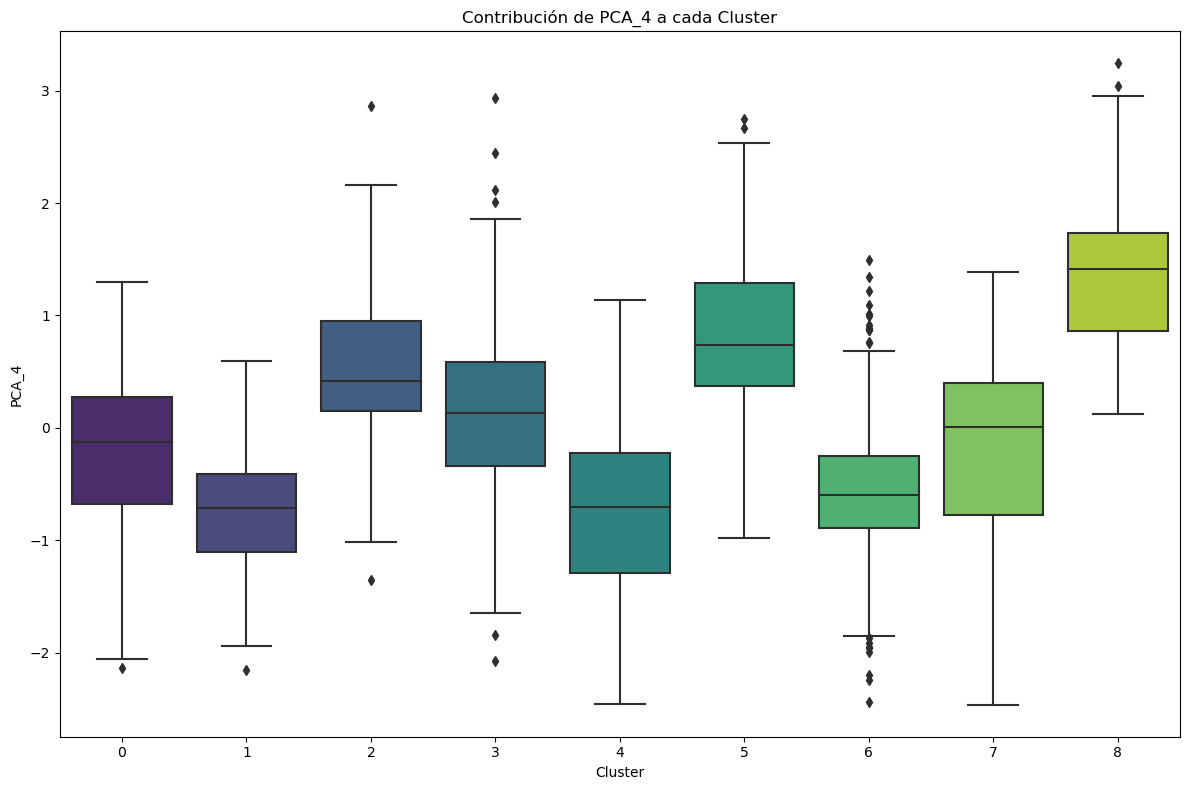

<Figure size 640x480 with 0 Axes>

In [52]:
# Gráfico de contribución de cada PCA a cada clúster
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='Cluster', y='PCA_1', palette='viridis')
plt.title('Contribución de PCA_1 a cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('PCA_1')
plt.tight_layout()
plt.savefig("resultados/contribucion_pca1_clusters.png")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='Cluster', y='PCA_2', palette='viridis')
plt.title('Contribución de PCA_2 a cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('PCA_2')
plt.tight_layout()
plt.savefig("resultados/contribucion_pca2_clusters.png")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='Cluster', y='PCA_3', palette='viridis')
plt.title('Contribución de PCA_3 a cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('PCA_3')
plt.tight_layout()
plt.savefig("resultados/contribucion_pca3_clusters.png")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='Cluster', y='PCA_4', palette='viridis')
plt.title('Contribución de PCA_4 a cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('PCA_4')
plt.tight_layout()
plt.savefig("resultados/contribucion_pca4_clusters.png")
plt.show()
plt.savefig("resultados/mejor_clustering.png")
plt.show()


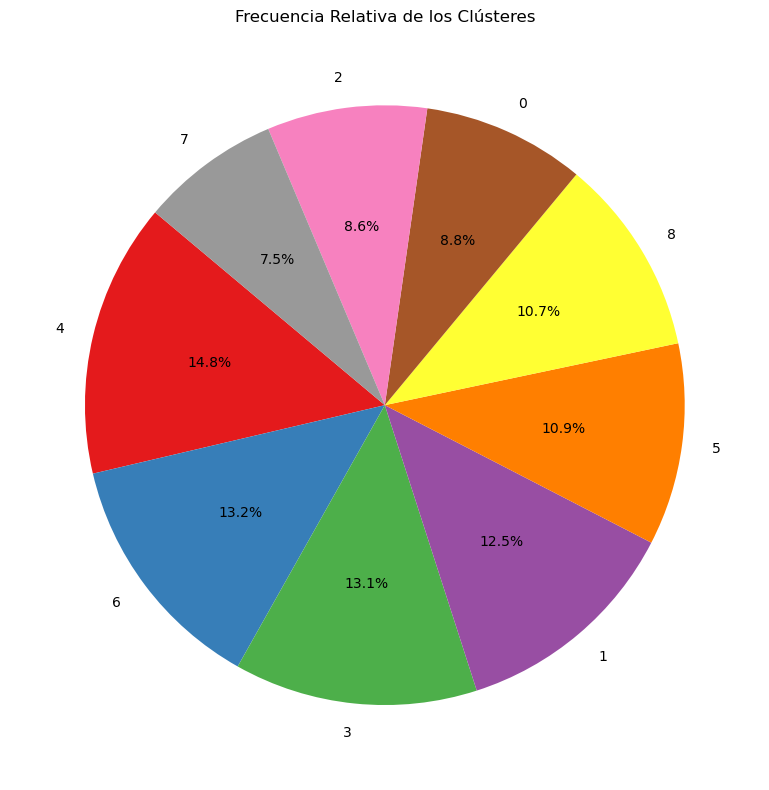

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Copia de los datos para análisis
result_data = X.copy()
data['NObeyesdad'] = y

# Crear una carpeta para guardar los resultados
os.makedirs("resultados", exist_ok=True)

# Asegurarse de que la columna 'Cluster' exista
# Verificar si la columna 'Cluster' ya existe en el DataFrame
if 'Cluster' not in data.columns:
    print("La columna 'Cluster' no existe en el DataFrame. Asegúrate de realizar el análisis de clustering primero.")
    exit()

if 'Cluster' in data.columns:
    # Calcular la frecuencia relativa de cada clúster
    cluster_counts = data['Cluster'].value_counts(normalize=True) * 100

    # Gráfico de pie para mostrar la frecuencia relativa de los clústeres
    plt.figure(figsize=(8, 8))
    plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set1'))
    plt.title('Frecuencia Relativa de los Clústeres')
    plt.tight_layout()

    # Guardar el gráfico de pie
    plt.savefig("resultados/frecuencia_relativa_clusters.png")
    plt.show()
else:
    print("La columna 'Cluster' no existe en el DataFrame. Asegúrate de realizar el análisis de clustering primero.")


In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Copia de los datos para análisis
result_data = X.copy()
result_data['NObeyesdad'] = y

# Código del PCA
quantitative_vars = result_data.select_dtypes(include=[np.number]).drop(columns=['NObeyesdad'], errors='ignore')
scaler = StandardScaler()
scaled_data = scaler.fit_transform(quantitative_vars)
pca = PCA(n_components=4)
pca_result = pca.fit_transform(scaled_data)
pca_columns = [f'PCA_{i+1}' for i in range(4)]
pca_df = pd.DataFrame(pca_result, columns=pca_columns)
result_data = pd.concat([result_data, pca_df], axis=1)

# Seleccionar los PCA como características y 'NObeyesdad' como objetivo
pca_columns = [col for col in result_data.columns if col.startswith('PCA_')]
if not pca_columns:
    raise ValueError("No se encontraron columnas de PCA en el DataFrame. Asegúrate de haber generado los PCA correctamente.")
X_pca = result_data[pca_columns]
y_target = result_data['NObeyesdad']

# Asegurarse de que no haya valores nulos en las características y objetivo seleccionados
X_pca = X_pca.fillna(0)
y_target = y_target.fillna(y_target.mode()[0])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_target, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)

# Probar diferentes modelos de clasificación
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Classifier': SVC(kernel='rbf', C=1, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Entrenar y evaluar cada modelo
train_accuracies = {}
test_accuracies = {}
best_model = None
best_accuracy = 0
for name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    # Evaluar precisión en entrenamiento
    train_accuracy = model.score(X_train, y_train)
    train_accuracies[name] = train_accuracy
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    # Evaluar la precisión
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies[name] = test_accuracy
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    # Guardar el mejor modelo
    if accuracy > best_accuracy:
        best_model = model
        best_accuracy = accuracy





Logistic Regression:
Accuracy: 0.59
                     precision    recall  f1-score   support

Insufficient_Weight       0.47      0.73      0.57        56
      Normal_Weight       0.31      0.18      0.22        62
     Obesity_Type_I       0.26      0.35      0.30        78
    Obesity_Type_II       0.64      0.60      0.62        58
   Obesity_Type_III       0.82      1.00      0.90        63
 Overweight_Level_I       0.25      0.21      0.23        56
Overweight_Level_II       0.07      0.02      0.03        50

           accuracy                           0.45       423
          macro avg       0.40      0.44      0.41       423
       weighted avg       0.40      0.45      0.42       423


K-Nearest Neighbors:
Accuracy: 0.59
                     precision    recall  f1-score   support

Insufficient_Weight       0.62      0.80      0.70        56
      Normal_Weight       0.43      0.31      0.36        62
     Obesity_Type_I       0.66      0.72      0.69        78
    Obe

Ambos modelos tienen exactitudes similares para predecir NObeyesdad. En este caso, la solución de seis perfiles en kmedias, parece mejor opción porque la complejidad del problema no parece ser resuelto solo con dos segmentos.

### Modelo optimizado
Partiendo de K-Nearest Neighbors como mejor modelo, se usa la variable Cluster para optimizar el modelo en un by

Precisión del modelo K-Nearest Neighbors con 'Cluster' como BY: 0.62


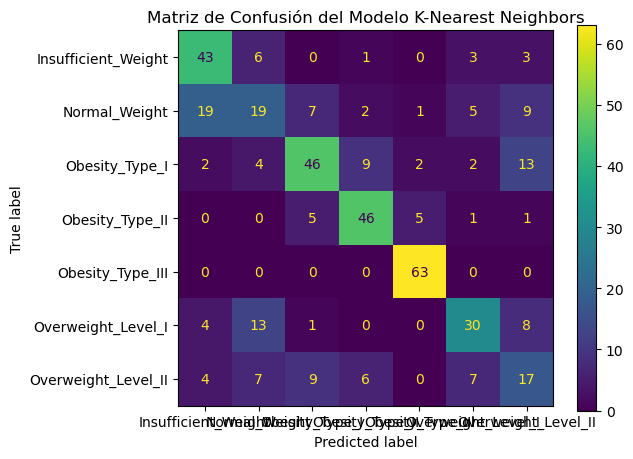

Precisión del modelo K-Nearest Neighbors con 'Cluster' como BY: 0.62


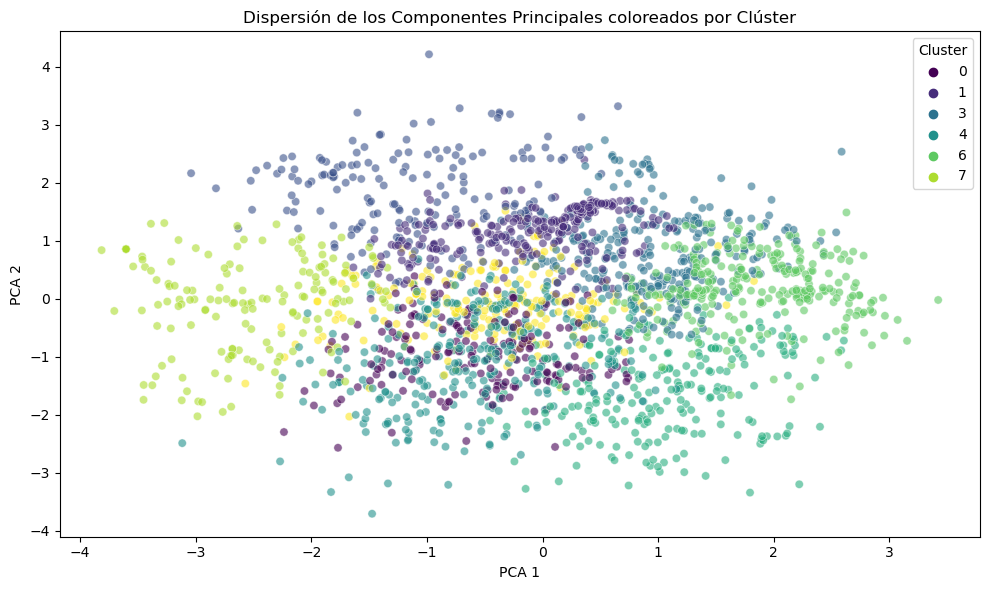

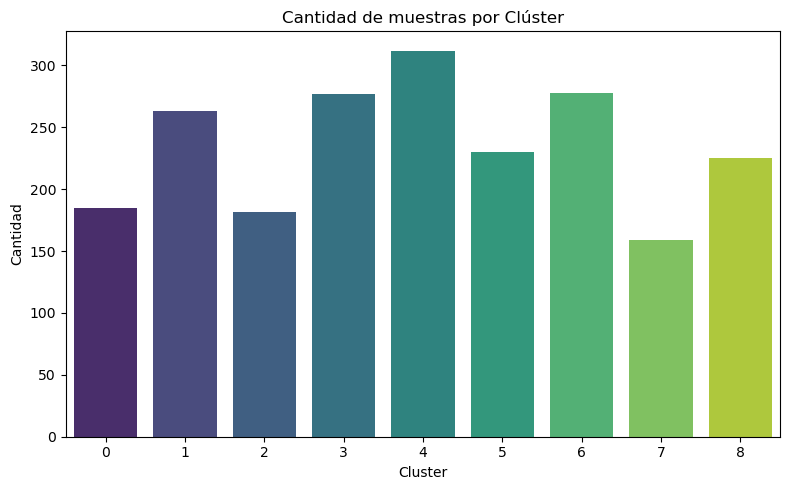

Contenido del DataFrame result_data:


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,FAF,TUE,CALC,MTRANS,NObeyesdad,PCA_1,PCA_2,PCA_3,PCA_4,Cluster
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,...,0.0,1.0,no,Public_Transportation,Normal_Weight,-1.333029,-0.689743,-0.305922,-0.733236,4
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,...,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,-0.087728,-0.727529,2.067507,2.956012,8
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,...,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,0.828980,-1.305978,-0.898384,0.475035,5
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,...,2.0,0.0,Frequently,Walking,Overweight_Level_I,1.305491,0.572544,0.366069,1.250744,3
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,...,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,-0.690310,0.842111,-0.478263,-0.111392,2


In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Copia de los datos para análisis
result_data = X.copy()
result_data['NObeyesdad'] = y

# Código del PCA
quantitative_vars = result_data.select_dtypes(include=[np.number]).drop(columns=['NObeyesdad'], errors='ignore')
scaler = StandardScaler()
scaled_data = scaler.fit_transform(quantitative_vars)
pca = PCA(n_components=4)
pca_result = pca.fit_transform(scaled_data)
pca_columns = [f'PCA_{i+1}' for i in range(4)]
pca_df = pd.DataFrame(pca_result, columns=pca_columns)
result_data = pd.concat([result_data, pca_df], axis=1)

# Seleccionar los PCA como características y 'NObeyesdad' como objetivo
pca_columns = [col for col in result_data.columns if col.startswith('PCA_')]
if not pca_columns:
    raise ValueError("No se encontraron columnas de PCA en el DataFrame. Asegúrate de haber generado los PCA correctamente.")
X_pca = result_data[pca_columns]
y_target = result_data['NObeyesdad']

# Asegurarse de que no haya valores nulos en las características y objetivo seleccionados
X_pca = X_pca.fillna(0)
y_target = y_target.fillna(y_target.mode()[0])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_target, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)


# Crear la columna 'Cluster' usando KMeans con 9 clusters basado solo en los PCA
kmeans = KMeans(n_clusters=9, random_state=42)
result_data['Cluster'] = kmeans.fit_predict(X_pca)
X_pca_cluster = pd.concat([X_pca, result_data['Cluster']], axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba para K-Nearest Neighbors
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_pca_cluster, y_target, test_size=0.2, random_state=42)

# Escalar las características para K-Nearest Neighbors
scaler_knn = StandardScaler()
X_train_knn = scaler_knn.fit_transform(X_train_knn.values)
X_test_knn = scaler_knn.transform(X_test_knn.values)

# Entrenar y evaluar el modelo K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_knn, y_train_knn)
knn_accuracy = knn_model.score(X_test_knn, y_test_knn)
print(f"Precisión del modelo K-Nearest Neighbors con 'Cluster' como BY: {knn_accuracy:.2f}")

# Gráfico de la matriz de confusión para visualizar el rendimiento del K-Nearest Neighbors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Realizar predicciones
y_pred_knn = knn_model.predict(X_test_knn)

# Crear la matriz de confusión
cm = confusion_matrix(y_test_knn, y_pred_knn, labels=knn_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_).plot(cmap='viridis')
plt.title('Matriz de Confusión del Modelo K-Nearest Neighbors')
plt.tight_layout()
plt.savefig("resultados/matriz_confusion_knn.png")
plt.show()


X_pca_cluster = pd.concat([X_pca, result_data['Cluster']], axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba para K-Nearest Neighbors
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_pca_cluster, y_target, test_size=0.2, random_state=42)

# Escalar las características para K-Nearest Neighbors
scaler_knn = StandardScaler()
X_train_knn = scaler_knn.fit_transform(X_train_knn)
X_test_knn = scaler_knn.transform(X_test_knn)

# Entrenar y evaluar el modelo K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_knn, y_train_knn)
knn_accuracy = knn_model.score(X_test_knn, y_test_knn)
print(f"Precisión del modelo K-Nearest Neighbors con 'Cluster' como BY: {knn_accuracy:.2f}")

# Gráficos para visualizar los patrones encontrados
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de dispersión de los PCA coloreados por clúster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Cluster', data=result_data, palette='viridis', alpha=0.6)
plt.title('Dispersión de los Componentes Principales coloreados por Clúster')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig("resultados/dispersión_pca_clusters.png")
plt.show()

# Gráfico de barras de la cantidad de muestras por clúster
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=result_data, palette='viridis')
plt.title('Cantidad de muestras por Clúster')
plt.xlabel('Cluster')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.savefig("resultados/cantidad_muestras_por_cluster.png")
plt.show()

print("Contenido del DataFrame result_data:")
display(result_data.head())



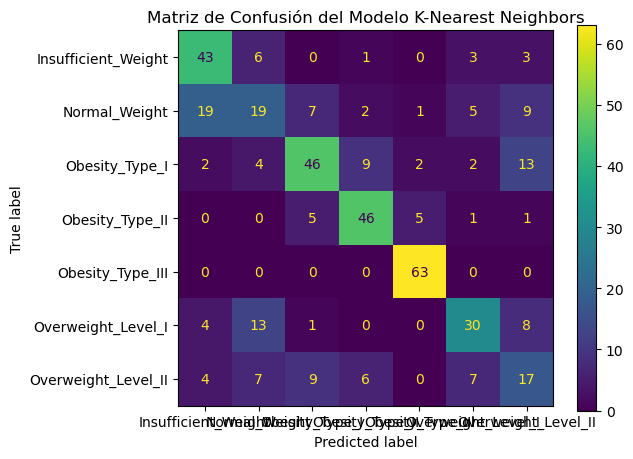

In [100]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test_knn, y_pred_knn, labels=knn_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_).plot(cmap='viridis')
plt.title('Matriz de Confusión del Modelo K-Nearest Neighbors')
plt.tight_layout()
plt.savefig("resultados/matriz_confusion_knn.png")
plt.show()
